### A. Import relevant dependencies

In [12]:
#! pip install langchain-text-splitters

In [13]:
import json
import os
import pickle
import sys

import networkx as nx
import pandas as pd
#import gremlin_python
from langchain_text_splitters import RecursiveCharacterTextSplitter

try:
    # This will work in scripts where __file__ is defined
    current_dir = os.path.dirname(os.path.abspath(__file__))
    # Assuming "src" is parallel to the script folder
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
except NameError:
    # In notebooks __file__ is not defined: assume we're in notebooks/multihop_dataset/
    project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

## B. Building the graph

### B.0 Settings and data loading

In [14]:
# Define parameters governing text chunking: chunk length (n words) and overlap size (s words)
n = 5000  # Number of words per chunk
s = 200   # Overlap size

# Save graph after creation?
save_graph = True

In [15]:
# Define path to corpus file and load it
multihop_corpus_path = os.path.join(project_root, "data", "Multi-hop_RAG_dataset", "inputs", "corpus.json")

with open(multihop_corpus_path, "r", encoding="utf-8") as f:
    corpus = json.load(f)

# Convert corpus data into df
corpus_as_df = pd.DataFrame(corpus)

# Add new feature to act as a unique identifier for each article
corpus_as_df["article_id"] = corpus_as_df.index.copy()

corpus_as_df["author"] = corpus_as_df["author"].fillna("unknown")

corpus_as_df.head()

,title,author,source,published_at,category,url,body,article_id
0,200+ of the best deals from Amazon's Cyber Mon...,unknown,Mashable,2023-11-27T08:45:59+00:00,entertainment,https://mashable.com/article/cyber-monday-deal...,"Table of Contents Table of Contents Echo, Fire...",0
1,ASX set to drop as Wall Street’s September slu...,Stan Choe,The Sydney Morning Herald,2023-09-26T19:11:30+00:00,business,https://www.smh.com.au/business/markets/asx-se...,"ETF provider Betashares, which manages $30 bil...",1
2,Amazon sellers sound off on the FTC's 'long-ov...,unknown,Cnbc | World Business News Leader,2023-10-06T21:31:00+00:00,business,https://www.cnbc.com/2023/10/06/amazon-sellers...,A worker sorts out parcels in the outbound doc...,2
3,"Christmas Day preview: 49ers, Ravens square of...","Colum Dell, Yardbarker",Yardbarker,2023-12-24T23:34:39+00:00,sports,https://www.yardbarker.com/nfl/articles/christ...,"Christmas Day isn't just for the NBA, as the N...",3
4,"Raiders vs. Lions live score, updates, highlig...",Dan Treacy,Sporting News,2023-10-30T22:20:03+00:00,sports,https://www.sportingnews.com/us/nfl/news/raide...,The Lions just needed to get themselves back i...,4


### B.1 Building the base graph

In [16]:
#-------------------------------
# Graph Creation (Excluding Text)
#-------------------------------

# Instatiate graph (Directed)
G = nx.DiGraph()

# Define sets to store unique authors, sources, and categories and avoid duplicates
authors = set()
sources = set()
categories = set()

# Iterate over rows in corpus df adding add nodes and edges to graph...
for i, row in corpus_as_df.iterrows():

    # Retrieve relevant data from row
    article_id = row["article_id"]
    author_id = row["author"]
    source_id = row["source"]
    category_id = row["category"]

    # Add article node to the graph
    G.add_node(article_id, type="article", title=row["title"], category=category_id, source=source_id, author=author_id)

    # Add the article's author to the graph if it is not present already
    if author_id not in authors:
        authors.add(author_id)
        G.add_node(author_id, type="author")

    # Add Article<-->Author edges
    G.add_edge(article_id, author_id, relation="WRITTEN_BY")  # (Ar -> Au)
    G.add_edge(author_id, article_id, relation="AUTHORED")    # (Au -> Ar)

    # Add the article's source to the graph if it is not present already
    if source_id not in sources:
        sources.add(source_id)
        G.add_node(source_id, type="source")

    # Add Article<-->Source edges
    G.add_edge(article_id, source_id, relation="PUBLISHED_IN")  # (Ar -> So)
    G.add_edge(source_id, article_id, relation="PUBLISHES")     # (So -> Ar)

    # Add the article's category to the graph if it is not present already
    if category_id not in categories:
        categories.add(author_id)
        G.add_node(category_id, type="category")

    # Add Article<-->Category edges
    G.add_edge(article_id, category_id, relation="CLASSIFIED_WITHIN")  # (Ar -> Ca)
    G.add_edge(category_id, article_id, relation="COVERED_IN")         # (Ca -> Ar)

In [17]:
# Get node types and edge relations counts
node_types = [G.nodes[node]['type'] for node in G.nodes()]
edge_relations = [G.edges[edge]['relation'] for edge in G.edges()]

print("\n=== GRAPH STATISTICS ===")
print(f"1. Total nodes: {G.number_of_nodes()}")
print(f"2. Total edges: {G.number_of_edges()}")

print("\n3. Nodes by type:")
for node_type in set(node_types):
    count = node_types.count(node_type)
    print(f"   - {node_type}: {count} nodes")

print("\n4. Edges by relation:")
for relation in set(edge_relations):
    count = edge_relations.count(relation)
    print(f"   - {relation}: {count} edges")


=== GRAPH STATISTICS ===
1. Total nodes: 962
2. Total edges: 3630

3. Nodes by type:
   - category: 6 nodes
   - source: 47 nodes
   - author: 300 nodes
   - article: 609 nodes

4. Edges by relation:
   - PUBLISHED_IN: 609 edges
   - WRITTEN_BY: 597 edges
   - CLASSIFIED_WITHIN: 609 edges
   - AUTHORED: 597 edges
   - COVERED_IN: 609 edges
   - PUBLISHES: 609 edges


### B.2 Adding non-article edges

In [18]:
# A. For each author, get the list of sources they've written for
author_sources = corpus_as_df.groupby('author')['source'].unique().apply(list).to_dict()

# B. For each author, get the list of categories they've written about
author_categories = corpus_as_df.groupby('author')['category'].unique().apply(list).to_dict()

# C. For each source, get the list of categories it covers
source_categories = corpus_as_df.groupby('source')['category'].unique().apply(list).to_dict()

# Display the results
print("A. Author -> Sources:\n", author_sources)
print("\nB. Author -> Categories:\n", author_categories)
print("\nC. Source -> Categories:\n", source_categories)

#-------------------------------
# Adding non-author Edges
#-------------------------------

# 1. Author -> Category relationships
print("Adding Author-Category relationships...")
for author, categories in author_categories.items():
    for category in categories:
        # Add bidirectional edges between author and category
        G.add_edge(author, category, relation="WRITES_ABOUT")        # (Au -> Ca)
        G.add_edge(category, author, relation="COVERED_BY_AUTHOR")   # (Ca -> Au)

# 2. Author -> Source relationships
print("Adding Author-Source relationships...")
for author, sources in author_sources.items():
    for source in sources:
        # Add bidirectional edges between author and source
        G.add_edge(author, source, relation="CONTRIBUTES_TO")        # (Au -> So)
        G.add_edge(source, author, relation="CONTRIBUTED_BY")        # (So -> Au)

# 3. Source -> Category relationships
print("Adding Source-Category relationships...")
for source, categories in source_categories.items():
    for category in categories:
        # Add bidirectional edges between source and category
        G.add_edge(source, category, relation="COVERS")              # (So -> Ca)
        G.add_edge(category, source, relation="COVERED_BY_SOURCE")   # (Ca -> So)

# Print summary of new edges added
print("\n=== NEW EDGES SUMMARY ===")
print(f"1. Total edges in graph: {G.number_of_edges()}")
print("\n2. New edge types added:")
edge_relations = [G.edges[edge]['relation'] for edge in G.edges()]
for relation in set(edge_relations):
    count = edge_relations.count(relation)
    print(f"   - {relation}: {count} edges")


A. Author -> Sources:
 {'': ['The Independent - Life and Style', 'The Age', 'The Sydney Morning Herald', 'The Independent - Travel'], 'Abe Beame': ['Polygon'], 'Adriana Morga, The Associated Press': ['Fortune'], 'Aidan Wohl, GoAZCATS.com': ['Rivals'], 'Alex Wilhelm': ['TechCrunch'], 'Alice Newcome-Beill': ['Polygon'], 'Alicia Haddick': ['The Verge'], 'Alyssa Stringer': ['TechCrunch'], 'Amanda Chicago Lewis': ['The Verge'], 'Amanda Silberling': ['TechCrunch'], 'Amber Raiken': ['The Independent - Life and Style'], 'Amy Beth Hanson, The Associated Press': ['Fortune'], 'Amy Skorheim': ['Engadget'], 'Anat-Daniely Lev': ['Globes English | Israel Business Arena'], 'Andreas Hale': ['Sporting News'], 'Andrew J. Hawkins': ['The Verge'], 'Andrew Tarantola': ['Engadget'], 'Andy Hunter': ['The Guardian'], 'Andy Hunter at Anfield': ['The Guardian'], 'Anna Heim': ['TechCrunch'], 'Annabel Streets': ['The Guardian'], 'Ansuman Abhisek': ['Essentially Sports'], 'Anthony Franco, MLB Trade Rumors': ['Yardb

In [19]:
# Get node types and edge relations counts
node_types = [G.nodes[node]['type'] for node in G.nodes()]
edge_relations = [G.edges[edge]['relation'] for edge in G.edges()]

print("\n=== GRAPH STATISTICS ===")
print(f"1. Total nodes: {G.number_of_nodes()}")
print(f"2. Total edges: {G.number_of_edges()}")

print("\n3. Nodes by type:")
for node_type in set(node_types):
    count = node_types.count(node_type)
    print(f"   - {node_type}: {count} nodes")

print("\n4. Edges by relation:")
for relation in set(edge_relations):
    count = edge_relations.count(relation)
    print(f"   - {relation}: {count} edges")


=== GRAPH STATISTICS ===
1. Total nodes: 962
2. Total edges: 4993

3. Nodes by type:
   - category: 6 nodes
   - source: 47 nodes
   - author: 300 nodes
   - article: 609 nodes

4. Edges by relation:
   - PUBLISHED_IN: 609 edges
   - WRITTEN_BY: 597 edges
   - CLASSIFIED_WITHIN: 609 edges
   - AUTHORED: 597 edges
   - CONTRIBUTED_BY: 319 edges
   - COVERED_IN: 609 edges
   - COVERED_BY_SOURCE: 58 edges
   - PUBLISHES: 609 edges
   - WRITES_ABOUT: 306 edges
   - COVERS: 58 edges
   - CONTRIBUTES_TO: 316 edges
   - COVERED_BY_AUTHOR: 306 edges


### B.3 Adding text chunks to the base graph

In [20]:
#-------------------------------
# Add Text to Graph
#-------------------------------

# Iterate through each article node in the graph
for article_id in range(len(corpus_as_df)):  # Assuming article IDs are sequential from 0 to 608

    # Retrieve the article's text from corpus DataFrame
    article_text = corpus_as_df.loc[article_id, "body"]
    article_author = corpus_as_df.loc[article_id, "author"]
    article_category = corpus_as_df.loc[article_id, "category"]
    article_source = corpus_as_df.loc[article_id, "source"]

    # Skip articles with missing or non-string text
    if pd.isna(article_text) or not isinstance(article_text, str):
        continue  

    # Text chunking (Employing LangChain's RecursiveCharacterTextSplitter)
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=n, chunk_overlap=s)
    chunks = text_splitter.split_text(article_text)

    # Add each chunk as a new node and connect it to the article
    chunk_nodes = []
    
    # For each generated chunk...
    for i, chunk_text in enumerate(chunks):

        # Assign unique chunk ID
        chunk_id = f"{article_id}_chunk_{i}"  

        # Add chunk node to the graph
        G.add_node(chunk_id, type="chunk", category=article_category, source=article_source, author=article_author, text=chunk_text)

        # Add Chunk<-->Article edges
        G.add_edge(article_id, chunk_id, relation="CONTAINS")
        G.add_edge(chunk_id, article_id, relation="BELONGS_TO")

        # Store chunk nodes for sequential linking
        chunk_nodes.append(chunk_id)

    # Add Chunk<-->Article edges between sequential chunks
    for i in range(len(chunk_nodes) - 1):
        G.add_edge(chunk_nodes[i], chunk_nodes[i + 1], relation="NEXT_CHUNK")
        G.add_edge(chunk_nodes[i + 1], chunk_nodes[i], relation="PREVIOUS_CHUNK")


In [21]:
# Get node types and edge relations counts
node_types = [G.nodes[node]['type'] for node in G.nodes()]
edge_relations = [G.edges[edge]['relation'] for edge in G.edges()]

print("\n=== GRAPH STATISTICS ===")
print(f"1. Total nodes: {G.number_of_nodes()}")
print(f"2. Total edges: {G.number_of_edges()}")

print("\n3. Nodes by type:")
for node_type in set(node_types):
    count = node_types.count(node_type)
    print(f"   - {node_type}: {count} nodes")

print("\n4. Edges by relation:")
for relation in set(edge_relations):
    count = edge_relations.count(relation)
    print(f"   - {relation}: {count} edges")


=== GRAPH STATISTICS ===
1. Total nodes: 2622
2. Total edges: 10415

3. Nodes by type:
   - category: 6 nodes
   - chunk: 1660 nodes
   - author: 300 nodes
   - source: 47 nodes
   - article: 609 nodes

4. Edges by relation:
   - BELONGS_TO: 1660 edges
   - PUBLISHED_IN: 609 edges
   - WRITTEN_BY: 597 edges
   - CLASSIFIED_WITHIN: 609 edges
   - AUTHORED: 597 edges
   - CONTRIBUTED_BY: 319 edges
   - PREVIOUS_CHUNK: 1051 edges
   - CONTAINS: 1660 edges
   - COVERED_IN: 609 edges
   - COVERED_BY_SOURCE: 58 edges
   - PUBLISHES: 609 edges
   - WRITES_ABOUT: 306 edges
   - COVERS: 58 edges
   - CONTRIBUTES_TO: 316 edges
   - NEXT_CHUNK: 1051 edges
   - COVERED_BY_AUTHOR: 306 edges


### B.4 Save Graph

In [22]:
# Save graph as .pkl
if save_graph:
    with open(os.path.join(project_root, "data", "Multi-hop_RAG_dataset", "intermediate", "base_document_graph.pkl"), "wb") as f:
        pickle.dump(G, f)
    print("Graph saved!")

Graph saved!


## C. Exploring the graph

In [12]:
import matplotlib.pyplot as plt

In [13]:
def visualize_node_neighbors(G, node_id):
    """
    Visualizes the neighborhood of a given node in a NetworkX graph.

    This function extracts a subgraph containing the specified node and all its directly 
    connected neighbors, then visualizes it using Matplotlib. The selected node is highlighted 
    in red, while its neighbors are displayed in light blue. If the graph is directed, 
    arrows indicate edge direction.

    Parameters:
    -----------
    G : networkx.Graph or networkx.DiGraph
        The input graph where the node and its neighbors exist.
    node_id : str or int
        The identifier of the node whose neighborhood is to be visualized.

    Returns:
    --------
    None
        Displays a Matplotlib plot of the subgraph.
    """
    if node_id not in G:
        print(f"Node '{node_id}' not found in the graph.")
        return
    
    # Create a subgraph with the node and its neighbors
    neighbors = list(G.neighbors(node_id))  # Get all connected nodes
    subgraph_nodes = [node_id] + neighbors  # Include the target node
    subgraph = G.subgraph(subgraph_nodes)   # Create subgraph

    # Draw the subgraph
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(subgraph, seed=42)  # Layout for better visualization
    nx.draw(subgraph, pos, with_labels=True, node_size=800, node_color="lightblue", edge_color="gray", font_size=8)
    nx.draw_networkx_edges(subgraph, pos, arrowstyle="->", arrowsize=15)

    # Highlight the selected node in red
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node_id], node_color="red", node_size=1000)

    plt.title(f"Neighborhood of Node: {node_id}")
    plt.show()

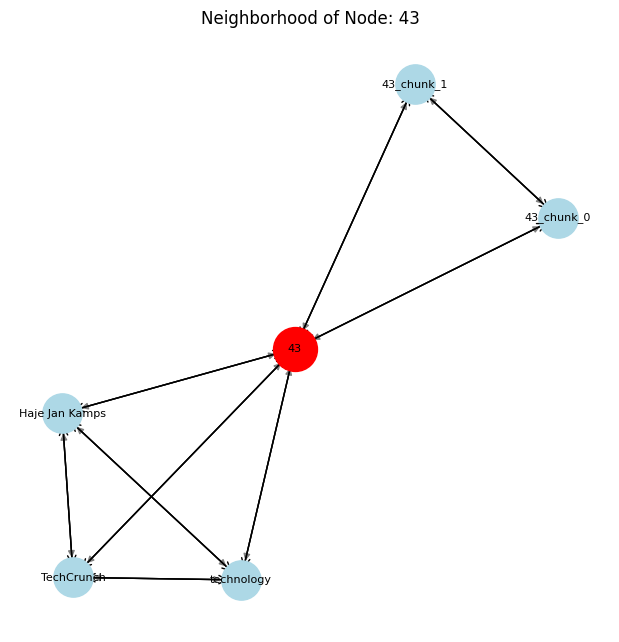

In [18]:
# Example 1: Visualize the neighborhood of node "5" (Article ID 5).
visualize_node_neighbors(G, 43) 

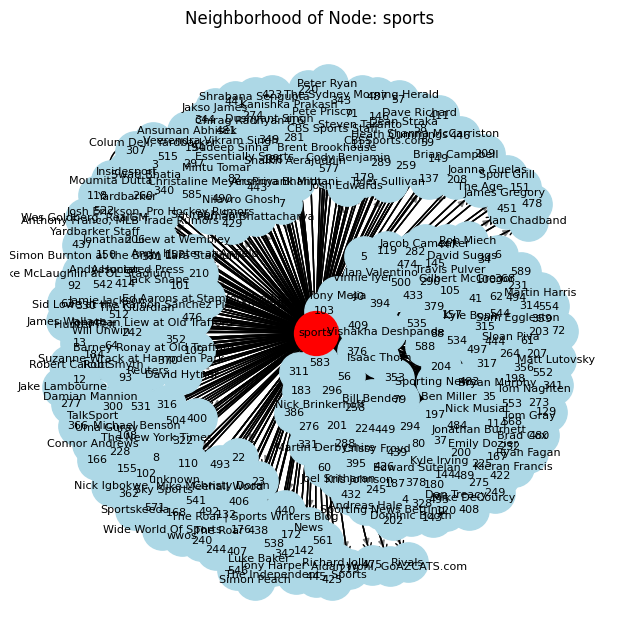

In [15]:
# Example 2: Visualize the neighborhood of node "sports" (Category "sports").
visualize_node_neighbors(G, "sports") 

In [16]:
def get_chunk_text(G, chunk_id):
    """
    Retrieves the text content of a specified chunk node in the graph.

    Parameters:
    -----------
    G : networkx.Graph or networkx.DiGraph
        The input graph where the chunk nodes exist.
    chunk_id : str or int
        The identifier of the chunk whose text content is to be retrieved.

    Returns:
    --------
    str
        The text content of the specified chunk, or a message if the chunk is not found.
    """
    if chunk_id not in G:
        return f"Chunk '{chunk_id}' not found in the graph."

    # Retrieve the chunk's text from its attributes
    chunk_text = G.nodes[chunk_id].get("text", "No text available")

    return chunk_text

## Not working below

In [17]:
## Load baseline graph
#with open("../data/MultiHop_graph_w_sem_embeddings.pkl", "rb") as f:
#    G = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../data/MultiHop_graph_w_sem_embeddings.pkl'

In [22]:
## Example: Retrieve the text content of a specific chunk node.
#chunk_id = "31_chunk_1"  
#print(get_chunk_text(G, chunk_id))

On Nov. 8, in the crypto exchange’s final few days, he tried to pull out his cash and crypto. How much? Almost $100,000, he said. And was he ever able to? “Never,” he told prosecutors.

Shortly afterward, as the trial neared late afternoon, the government called Adam Yedidia to the stand. A fast-talking graduate of MIT, he and Bankman-Fried were close friends in college, he said. And after Bankman-Fried left Jane Street, the high-frequency trading firm where the former billionaire got his start in finance after MIT, he persuaded Yedidia to join him as a trader at Alameda and then as a developer at FTX.

When Yedidia first took the stand, Danielle Sassoon, one of the lead prosecutors, said that the college friend of Bankman-Fried had legal immunity during his testimony. Why did he make such a deal with the government, she asked.

“I was concerned that I had unwittingly written code that contributed to a crime,” he said.

Soon, however, the clock neared 4:30 p.m., and court adjourned for

In [14]:
## Find all nodes of the type "article"
#articles = [n for n, d in G.nodes(data=True) if d.get("type") == "article"]
#print("Articles:", articles)

Articles: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [15]:
## Function to get details of a specific node
#def get_node_details(G, node_id):
#    """
#    Display details of a specific node in a graph.
#
#    Parameters:
#    -----------
#    G : networkx.Graph or networkx.DiGraph
#        The graph containing the node.
#    node_id : str
#        The ID of the node to retrieve.
#
#    Returns:
#    --------
#    str or None
#        An error message if the node is not found; otherwise, prints node details.
#    if node_id not in G:
#        return f"Node '{node_id}' not found in the graph.""
#    """
#    
#    # Get node attributes
#    node_attributes = G.nodes[node_id]
#
#    # Get all connected nodes (neighbors)
#    neighbors = list(G.neighbors(node_id))
#
#    # Get predecessors (incoming edges)
#    predecessors = list(G.predecessors(node_id)) if isinstance(G, nx.DiGraph) else None
#
#    # Get successors (outgoing edges)
#    successors = list(G.successors(node_id)) if isinstance(G, nx.DiGraph) else None
#
#    # Get edges related to the node
#    edges = list(G.edges(node_id, data=True))
#
#    # Print details
#    print(f"📌 **Node ID:** {node_id}")
#    print(f"🔹 **Attributes:** {node_attributes}")
#    print(f"🔗 **Neighbors:** {neighbors}")
#    if predecessors is not None:
#        print(f"⬅️ **Predecessors (incoming edges):** {predecessors}")
#    if successors is not None:
#        print(f"➡️ **Successors (outgoing edges):** {successors}")
#    print(f"🔄 **Edges:** {edges}")

In [30]:
## Example usage
#get_node_details(G, 53) 

📌 **Node ID:** 53
🔹 **Attributes:** {'type': 'article', 'title': 'The jury finally hears from Sam Bankman-Fried', 'category': 'technology', 'source': 'The Verge', 'author': 'Elizabeth Lopatto', 'embedding': [-0.6905026882886887, -0.1212612787882487, -0.3558054467042287, -0.01981214185555776, 0.07226171096165974, -0.1924774143844843, 0.7912332018216451, 0.8325122992197672, -0.2437898317972819, 0.37721045315265656, 0.0497041717171669, 0.3963468198974927, -0.48503054678440094, 0.01070078710714976, -0.1822327139476935, -0.5086280362059673, -0.0019528691967328389, -0.5095643103122711, -0.851123626033465, -0.00821387767791748, -0.7116852104663849, -0.09298561016718547, 0.33473367989063263, 0.572166363398234, -0.22794641057650247, 1.2352174172798793, -0.8088381588459015, -0.30983124673366547, -0.11579527457555135, 0.46708916624387103, -0.0492254247268041, 0.06559225420157115, 0.16342504819234213, -0.034109920263290405, -0.19910234957933426, -0.3669378062089284, 0.15638316671053568, -0.5135396

Non-interactive visualization of the entire graph

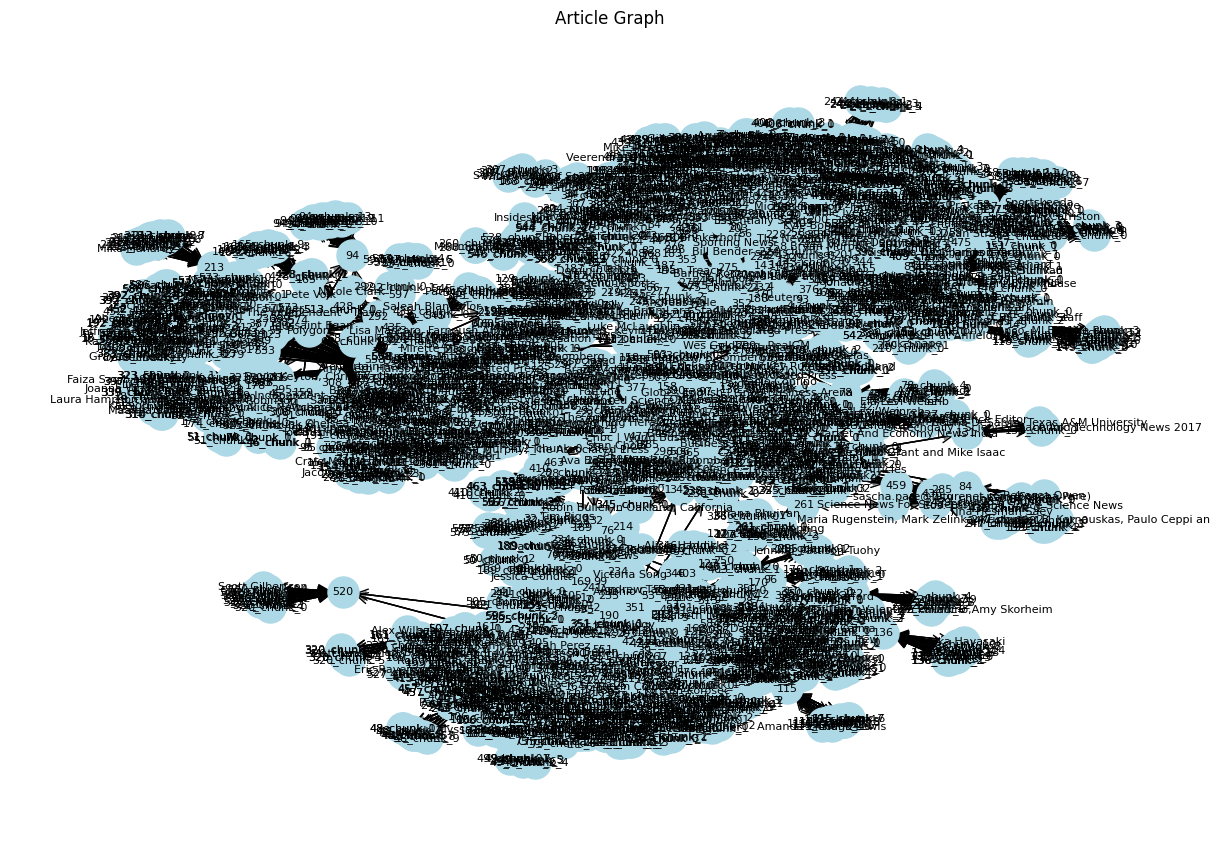

In [17]:
## Non-interactive plot of the entire graph
#plt.figure(figsize=(12, 8))
#pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
#nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, node_color="lightblue", edge_color="gray")
#nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)
#plt.title("Article Graph")
#plt.show()